In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import package
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import json
import torch
from pretrain_hierar import arg_parse, generate_reaction_reps, calculate_map
from utils.build_utils import build_retro_iterator, build_model, load_checkpoint
from utils.smiles_utils import clear_map_number
from models.model import ProjectNet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

In [4]:
query_set = pd.read_csv("./data/uspto_1K_TPL_backward/retrieval_query_set.csv")
gallery_set = pd.read_csv("./data/uspto_1K_TPL_backward/retrieval_gallery_set.csv")

### HiCLR (w/o Retro)

In [4]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/wo_ar/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/wo_ar/model_pretrain_best_mAP.pt


In [5]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :10]  #*[num_query, r]
# retrieval_labels = gallery_labels.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]

# 3. calculate metric
for i in range(1, 11):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:02<00:00, 72.58it/s]


mAP@1=0.6266666650772095
mAP@2=0.6128333210945129
mAP@3=0.5990740656852722
mAP@4=0.5878472328186035
mAP@5=0.5785711407661438
mAP@6=0.5698277950286865
mAP@7=0.5617843866348267
mAP@8=0.5540612936019897
mAP@9=0.5464742183685303
mAP@10=0.538946807384491


### SelfCon

In [6]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/selfsup/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/selfsup/model_pretrain_best_mAP.pt


In [7]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :10]  #*[num_query, r]
# retrieval_labels = gallery_labels.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]

# 3. calculate metric
for i in range(1, 11):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 1/625 [00:00<01:08,  9.10it/s]

Iteration: 100%|██████████| 188/188 [00:02<00:00, 86.21it/s]


mAP@1=0.19466666877269745
mAP@2=0.17649999260902405
mAP@3=0.16322222352027893
mAP@4=0.15287500619888306
mAP@5=0.14438000321388245
mAP@6=0.13715000450611115
mAP@7=0.13082244992256165
mAP@8=0.125355064868927
mAP@9=0.12052961438894272
mAP@10=0.11636331677436829


In [32]:
retrieval_idx.shape

torch.Size([1500, 10])

In [5]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_gallery_ids

tensor([[   9, 1180, 2151,  ..., 2816, 2526, 2528],
        [3714, 4074, 1187,  ...,   94, 3519, 2650],
        [4966, 4053,  647,  ..., 2990,  432, 2993],
        ...,
        [3095, 4803, 1532,  ..., 1324, 4042, 2705],
        [ 630, 2471, 1384,  ..., 4512, 2130, 3025],
        [2467,  343, 3338,  ...,  751, 2941, 2245]], device='cuda:0')

In [34]:
retrieval_df = pd.DataFrame()
retrieval_df["query_ids"] = query_ids.cpu()
retrieval_df["selfsup_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids
0,0,"[9, 1180, 2151, 1185, 2156, 2520, 1249, 2816, ..."
1,1,"[3714, 4074, 1187, 4554, 2291, 4180, 3292, 94,..."
2,10,"[4966, 4053, 647, 433, 402, 1234, 2999, 2990, ..."
3,100,"[3728, 3261, 3307, 332, 336, 3335, 1633, 408, ..."
4,1000,"[662, 435, 4372, 2353, 2806, 63, 433, 268, 81,..."
...,...,...
1495,995,"[2150, 409, 4386, 2724, 3511, 181, 3315, 4242,..."
1496,996,"[3757, 511, 312, 3195, 1832, 2152, 798, 2145, ..."
1497,997,"[3095, 4803, 1532, 3640, 3645, 3091, 3098, 132..."
1498,998,"[630, 2471, 1384, 2689, 4507, 1583, 1209, 4512..."


In [17]:
gallery_set.superclass.unique()

array([ 7,  6,  2,  1,  3,  5,  8, 10,  9,  4,  0])

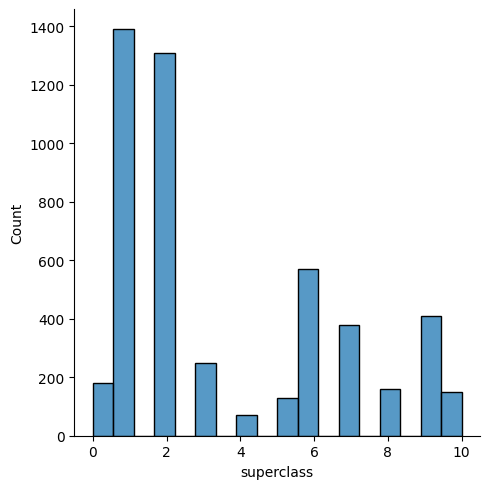

In [18]:
sns.displot(gallery_set.superclass)

In [24]:
# select 3 reaction in query set (class=0,1,3)
template_class = [0, 1, 3]
query_set[query_set["class"].isin(template_class)]

,id,reactants>reagents>production,class,retro_template,superclass
0,100235,O=[N+:12]([O-])[c:11]1[cH:10][cH:9][cH:8][c:7]...,1,([NH2;D1;+0:1]-[c:2])>>(O=[N+;H0;D3:1](-[O-])-...,7
1,400905,O=[N+:1]([O-])[c:2]1[cH:3][cH:4][c:5](-[c:6]2[...,1,([NH2;D1;+0:1]-[c:2])>>(O=[N+;H0;D3:1](-[O-])-...,7
2,57201,O=[N+:1]([O-])[c:2]1[cH:3][cH:4][cH:5][c:6](-[...,1,([NH2;D1;+0:1]-[c:2])>>(O=[N+;H0;D3:1](-[O-])-...,7
39,252217,Cl[S:12]([CH3:13])(=[O:14])=[O:15].[CH3:1][C:2...,0,([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3...,2
40,37236,Cl[S:8]([CH3:9])(=[O:10])=[O:11].[CH3:1][CH2:2...,0,([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3...,2
41,150931,Cl[S:12]([CH3:13])(=[O:14])=[O:15].[CH3:1][C:2...,0,([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3...,2
336,329638,O=S(Cl)[Cl:15].O[C:13]([c:12]1[c:3]([O:2][CH3:...,3,([Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-...,9
337,179086,O=S(Cl)[Cl:22].O[C:20]([c:19]1[cH:18][c:6]([O:...,3,([Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-...,9
338,22247,O=S(Cl)[Cl:13].O[C:11]([c:10]1[c:3]([O:2][CH3:...,3,([Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-...,9


In [14]:
retrieval_df[retrieval_df["query_ids"].isin([0, 39, 336])]

,query_ids,selfsup_gallery_ids
0,0,"[9, 2520, 2528, 2526, 2151]"
764,336,"[1223, 1125, 4048, 2932, 2937]"
823,39,"[135, 4037, 437, 4038, 2079]"


In [65]:
gallery_set[gallery_set.index.isin([1223, 1125, 4048, 2932, 2937])]

,id,reactants>reagents>production,class,retro_template,superclass
1125,98226,O=S(Cl)[Cl:13].O[C:11]([c:10]1[cH:9][c:8]2[cH:...,3,([Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-...,9
1223,220934,O=S(Cl)[Cl:12].O[CH2:11][c:10]1[cH:9][cH:8][cH...,81,([Cl;H0;D1;+0:1]-[CH2;D2;+0:2]-[c:3])>>(Cl-S(=...,9
2932,254606,Cl[C:8]([c:7]1[cH:6][cH:5][cH:4][c:3]([O:2][CH...,61,([O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[c;H0;D3;+...,0
2937,45360,Cl[C:7](=[O:8])[c:9]1[cH:10][cH:11][cH:12][cH:...,61,([O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[c;H0;D3;+...,0
4048,119095,O=P(Cl)(Cl)[Cl:8].O=[c:7]1[c:6]2[cH:5][cH:4][c...,100,([Cl;H0;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[n;H0;...,9


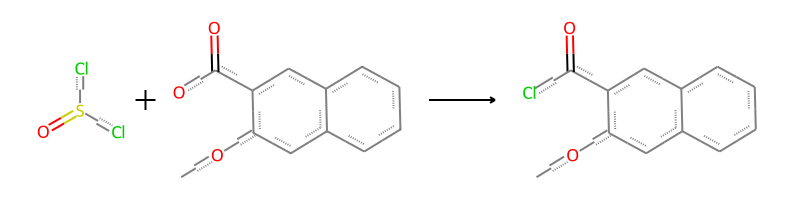

In [ ]:
rxn_smiles = query_set["reactants>reagents>production"][336]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

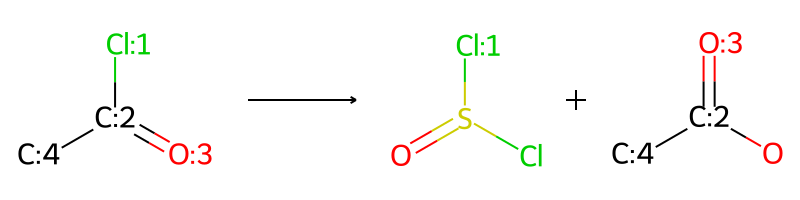

In [66]:
rxn_smiles = query_set["retro_template"][336]
# rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

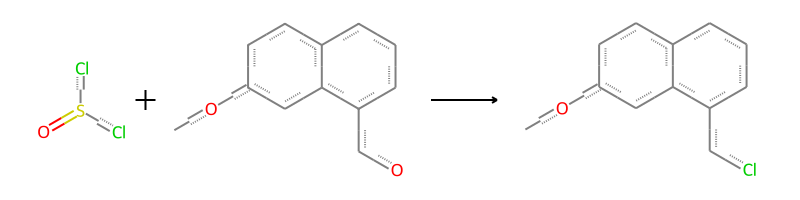

In [71]:
rxn_smiles = gallery_set["reactants>reagents>production"][1223]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

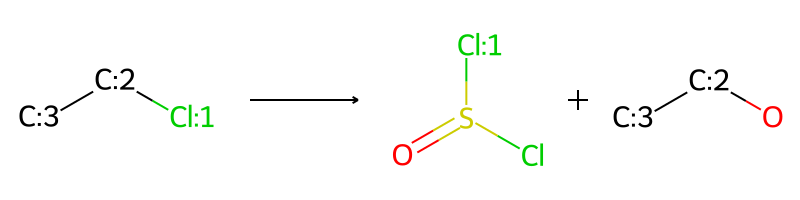

In [67]:
rxn_smiles = gallery_set["retro_template"][1223]

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

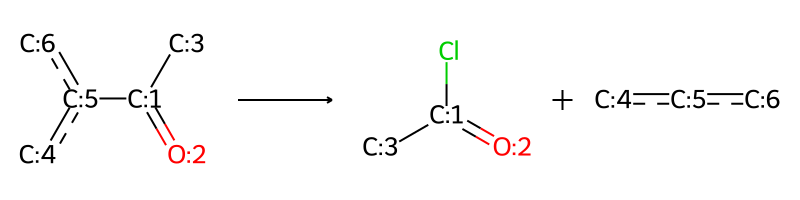

In [68]:
rxn_smiles = gallery_set["retro_template"][2932]

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

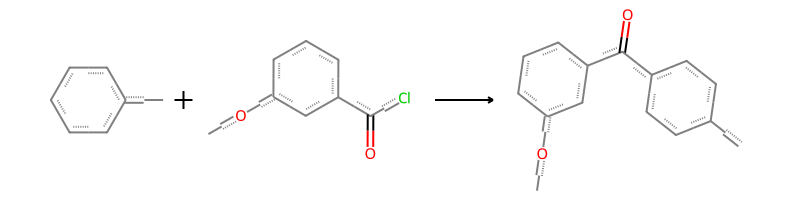

In [72]:
rxn_smiles = gallery_set["reactants>reagents>production"][2932]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

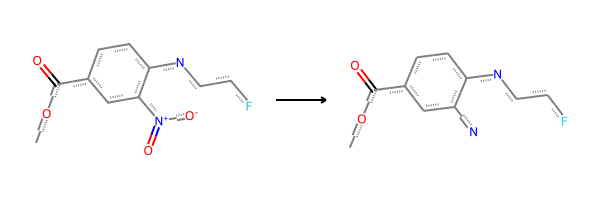

In [54]:
rxn_smiles = gallery_set["reactants>reagents>production"][2520]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

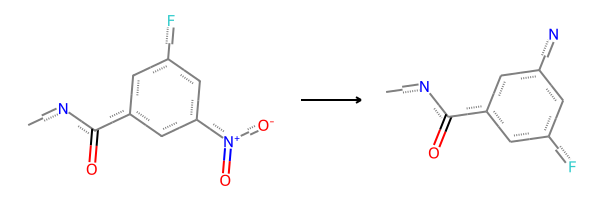

In [59]:
rxn_smiles = gallery_set["reactants>reagents>production"][2151]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))

rxn = AllChem.ReactionFromSmarts(rxn_smiles)
img = Draw.ReactionToImage(rxn)
img

### SupCon-N

In [8]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/supcon_namerxn/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/supcon_namerxn/model_pretrain_best_mAP.pt


In [9]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :10]  #*[num_query, r]

# 3. calculate metric
for i in range(1, 11):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:02<00:00, 88.20it/s]


mAP@1=0.27933332324028015
mAP@2=0.2549999952316284
mAP@3=0.23933333158493042
mAP@4=0.22737501561641693
mAP@5=0.21792666614055634
mAP@6=0.21023519337177277
mAP@7=0.20361655950546265
mAP@8=0.1977165788412094
mAP@9=0.1922912746667862
mAP@10=0.18738214671611786


In [37]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_df["supcon_namerxn_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids
0,0,"[9, 1180, 2151, 1185, 2156, 2520, 1249, 2816, ...","[2753, 2156, 2816, 2528, 2520, 4425, 4426, 331..."
1,1,"[3714, 4074, 1187, 4554, 2291, 4180, 3292, 94,...","[4424, 1119, 909, 5, 907, 4981, 3127, 3867, 22..."
2,10,"[4966, 4053, 647, 433, 402, 1234, 2999, 2990, ...","[4683, 33, 1438, 945, 38, 4243, 35, 2896, 4249..."
3,100,"[3728, 3261, 3307, 332, 336, 3335, 1633, 408, ...","[4018, 583, 4013, 337, 2097, 585, 4016, 589, 5..."
4,1000,"[662, 435, 4372, 2353, 2806, 63, 433, 268, 81,...","[300, 961, 2460, 243, 3413, 2503, 2462, 889, 9..."
...,...,...,...
1495,995,"[2150, 409, 4386, 2724, 3511, 181, 3315, 4242,...","[1114, 640, 184, 4426, 497, 2529, 901, 4425, 2..."
1496,996,"[3757, 511, 312, 3195, 1832, 2152, 798, 2145, ...","[4607, 4100, 4433, 1337, 1592, 2852, 4602, 109..."
1497,997,"[3095, 4803, 1532, 3640, 3645, 3091, 3098, 132...","[3095, 3098, 4758, 1063, 2764, 4626, 1061, 654..."
1498,998,"[630, 2471, 1384, 2689, 4507, 1583, 1209, 4512...","[1320, 1321, 3326, 152, 1152, 3320, 1371, 474,..."


### SupCon-T

In [10]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/supcon_template/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/


Loading checkpoint from ./result/uspto_1K_TPL_backward/final/supcon_template/model_pretrain_best_mAP.pt


In [11]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :10]  #*[num_query, r]

# 3. calculate metric
for i in range(1, 11):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:02<00:00, 85.80it/s]


mAP@1=0.9900000095367432
mAP@2=0.9896666407585144
mAP@3=0.9895555377006531
mAP@4=0.9892916083335876
mAP@5=0.988873302936554
mAP@6=0.9884313941001892
mAP@7=0.9880296587944031
mAP@8=0.9875676035881042
mAP@9=0.9870067238807678
mAP@10=0.9859859943389893


In [40]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_df["supcon_template_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids,supcon_template_gallery_ids
0,0,"[9, 1180, 2151, 1185, 2156, 2520, 1249, 2816, ...","[2753, 2156, 2816, 2528, 2520, 4425, 4426, 331...","[5, 1, 3, 7, 0, 2, 6, 8, 9, 4]"
1,1,"[3714, 4074, 1187, 4554, 2291, 4180, 3292, 94,...","[4424, 1119, 909, 5, 907, 4981, 3127, 3867, 22...","[0, 7, 1, 5, 3, 6, 2, 8, 9, 4]"
2,10,"[4966, 4053, 647, 433, 402, 1234, 2999, 2990, ...","[4683, 33, 1438, 945, 38, 4243, 35, 2896, 4249...","[4969, 32, 31, 36, 35, 37, 30, 39, 33, 38]"
3,100,"[3728, 3261, 3307, 332, 336, 3335, 1633, 408, ...","[4018, 583, 4013, 337, 2097, 585, 4016, 589, 5...","[332, 333, 336, 337, 331, 338, 335, 334, 330, ..."
4,1000,"[662, 435, 4372, 2353, 2806, 63, 433, 268, 81,...","[300, 961, 2460, 243, 3413, 2503, 2462, 889, 9...","[3339, 3333, 3338, 3331, 3335, 3332, 3330, 333..."
...,...,...,...,...
1495,995,"[2150, 409, 4386, 2724, 3511, 181, 3315, 4242,...","[1114, 640, 184, 4426, 497, 2529, 901, 4425, 2...","[3315, 3318, 3310, 3319, 3311, 3314, 3312, 331..."
1496,996,"[3757, 511, 312, 3195, 1832, 2152, 798, 2145, ...","[4607, 4100, 4433, 1337, 1592, 2852, 4602, 109...","[3321, 3325, 3326, 3320, 3329, 3323, 3322, 332..."
1497,997,"[3095, 4803, 1532, 3640, 3645, 3091, 3098, 132...","[3095, 3098, 4758, 1063, 2764, 4626, 1061, 654...","[3324, 3327, 3325, 3326, 3322, 3323, 3321, 332..."
1498,998,"[630, 2471, 1384, 2689, 4507, 1583, 1209, 4512...","[1320, 1321, 3326, 152, 1152, 3320, 1371, 474,...","[3325, 3320, 3321, 3322, 3323, 3326, 3327, 332..."


### HiCLR

In [14]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/supcon_hierar_align/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/supcon_hierar_align/model_pretrain_best_mAP.pt


In [15]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :5]  #*[num_query, r]

# 3. calculate metric
for i in range(1, 11):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:02<00:00, 87.36it/s]


mAP@1=0.9726666808128357
mAP@2=0.971666693687439
mAP@3=0.9708889126777649
mAP@4=0.9703333973884583
mAP@5=0.9695200324058533
mAP@6=0.9685630202293396
mAP@7=0.9674076437950134
mAP@8=0.9662526249885559
mAP@9=0.9647841453552246
mAP@10=0.9621657729148865


In [44]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_df["supcon_hierar_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids,supcon_template_gallery_ids,supcon_hierar_gallery_ids
0,0,"[9, 1180, 2151, 1185, 2156, 2520, 1249, 2816, ...","[2753, 2156, 2816, 2528, 2520, 4425, 4426, 331...","[5, 1, 3, 7, 0, 2, 6, 8, 9, 4]","[6, 0, 1, 9, 5]"
1,1,"[3714, 4074, 1187, 4554, 2291, 4180, 3292, 94,...","[4424, 1119, 909, 5, 907, 4981, 3127, 3867, 22...","[0, 7, 1, 5, 3, 6, 2, 8, 9, 4]","[0, 5, 6, 3, 9]"
2,10,"[4966, 4053, 647, 433, 402, 1234, 2999, 2990, ...","[4683, 33, 1438, 945, 38, 4243, 35, 2896, 4249...","[4969, 32, 31, 36, 35, 37, 30, 39, 33, 38]","[32, 4969, 38, 36, 31]"
3,100,"[3728, 3261, 3307, 332, 336, 3335, 1633, 408, ...","[4018, 583, 4013, 337, 2097, 585, 4016, 589, 5...","[332, 333, 336, 337, 331, 338, 335, 334, 330, ...","[332, 336, 333, 337, 330]"
4,1000,"[662, 435, 4372, 2353, 2806, 63, 433, 268, 81,...","[300, 961, 2460, 243, 3413, 2503, 2462, 889, 9...","[3339, 3333, 3338, 3331, 3335, 3332, 3330, 333...","[3335, 3330, 3331, 3339, 3332]"
...,...,...,...,...,...
1495,995,"[2150, 409, 4386, 2724, 3511, 181, 3315, 4242,...","[1114, 640, 184, 4426, 497, 2529, 901, 4425, 2...","[3315, 3318, 3310, 3319, 3311, 3314, 3312, 331...","[3315, 3311, 3318, 3319, 3317]"
1496,996,"[3757, 511, 312, 3195, 1832, 2152, 798, 2145, ...","[4607, 4100, 4433, 1337, 1592, 2852, 4602, 109...","[3321, 3325, 3326, 3320, 3329, 3323, 3322, 332...","[3320, 3326, 3321, 3322, 3324]"
1497,997,"[3095, 4803, 1532, 3640, 3645, 3091, 3098, 132...","[3095, 3098, 4758, 1063, 2764, 4626, 1061, 654...","[3324, 3327, 3325, 3326, 3322, 3323, 3321, 332...","[3324, 3321, 3326, 3323, 3329]"
1498,998,"[630, 2471, 1384, 2689, 4507, 1583, 1209, 4512...","[1320, 1321, 3326, 152, 1152, 3320, 1371, 474,...","[3325, 3320, 3321, 3322, 3323, 3326, 3327, 332...","[3326, 3320, 3327, 3324, 3321]"


### Visualization of similar templates

In [25]:
from rdkit import RDConfig
import unittest
import random
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import cairosvg
from IPython.display import Image

def visualize_rxn(rxn_smiles):
    rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
    rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
    img = Draw.ReactionToImage(rxn)
    return img

def visualize_tpl(tpl_smiles):
    tpl_smiles_r = ">>".join(tpl_smiles.split(">>")[::-1])
    tpl = AllChem.ReactionFromSmarts(tpl_smiles, useSmiles=False) #! atom idx
    img = Draw.ReactionToImage(tpl)
    return img

def visualize_tpl_with_c_type(tpl_smiles):
    # 反转反应方向
    tpl_smiles_r = ">>".join(tpl_smiles.split(">>")[::-1])
    tpl = AllChem.ReactionFromSmarts(tpl_smiles_r, useSmiles=False)

    # 遍历反应物、产物、试剂里的所有分子
    for mol_list in [tpl.GetReactants(), tpl.GetProducts(), tpl.GetAgents()]:
        for mol in mol_list:
            if mol is None:
                continue
            for atom in mol.GetAtoms():
                if atom.GetSymbol() == 'C':
                    if atom.GetIsAromatic():
                        atom.SetProp('atomNote', 'Aromatic')
                    else:
                        atom.SetProp('atomNote', 'Aliphatic')

    img = Draw.ReactionToImage(tpl, subImgSize=(300, 300))  # 可以调大subImgSize
    return img

In [16]:
def visualize_rxn_highlight(rxn_smiles, tpl_smiles, reaction_id=1):
    rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
    rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
    r_patt, p_patt = tpl_smiles.split(">>")
    p_patt = Chem.MolFromSmarts(p_patt)
    r_patt = Chem.MolFromSmarts(r_patt)
    for pidx, product in enumerate(rxn.GetProducts()):
        hit_at = product.GetSubstructMatch(p_patt)
        hit_bond = []
        for bond in p_patt.GetBonds():
            aid1 = hit_at[bond.GetBeginAtomIdx()]
            aid2 = hit_at[bond.GetEndAtomIdx()]
            hit_bond.append(product.GetBondBetweenAtoms(aid1, aid2).GetIdx())
        d = rdMolDraw2D.MolDraw2DCairo(500, 500)
        rdMolDraw2D.PrepareAndDrawMolecule(d, product, highlightAtoms=list(hit_at), highlightBonds=hit_bond)
        d.FinishDrawing()
        os.makedirs(f'figures/reactions/{reaction_id}')
        d.WriteDrawingText(f'figures/reactions/{reaction_id}/product_{pidx}.png')

    for ridx, reactant in enumerate(rxn.GetReactants()):
        hit_at = reactant.GetSubstructMatch(r_patt)
        hit_bond = []
        for bond in r_patt.GetBonds():
            aid1 = hit_at[bond.GetBeginAtomIdx()]
            aid2 = hit_at[bond.GetEndAtomIdx()]
            hit_bond.append(reactant.GetBondBetweenAtoms(aid1, aid2).GetIdx())
        d = rdMolDraw2D.MolDraw2DCairo(500, 500)
        rdMolDraw2D.PrepareAndDrawMolecule(d, reactant, highlightAtoms=list(hit_at), highlightBonds=hit_bond)
        d.FinishDrawing()
        d.WriteDrawingText(f'figures/reactions/{reaction_id}/reactant_{ridx}.png')

([C;D1;H3:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3])>>(O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]).([C;D1;H3:4]-[NH2;D1;+0:5])


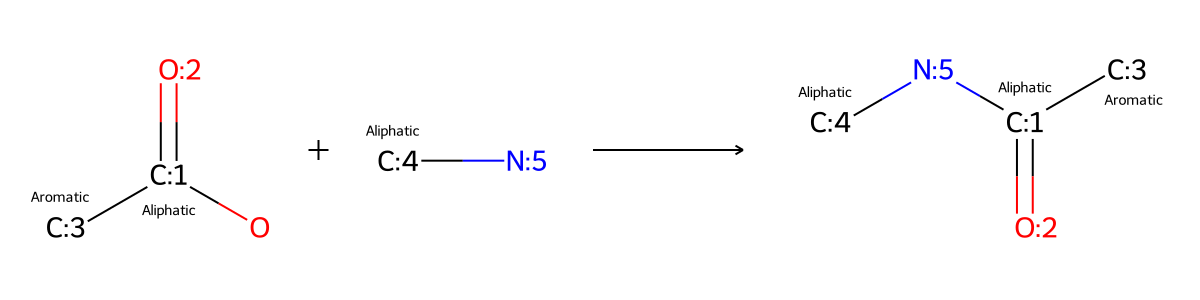

In [26]:
tpl_smiles = gallery_set[gallery_set["class"]==334].iloc[0]["retro_template"]
rxn_smiles = gallery_set[gallery_set["class"]==334].iloc[0]["reactants>reagents>production"]
print(tpl_smiles)
visualize_tpl_with_c_type(tpl_smiles)

O[C:3](=[O:4])[c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[n:11][c:12]([NH:13][c:14]1[n:15][c:16]3[cH:17][cH:18][c:19]([C:20]([F:21])([F:22])[F:23])[cH:24][c:25]3[s:26]1)[n:27]2[CH3:28].[CH3:1][NH2:2]>>[CH3:1][NH:2][C:3](=[O:4])[c:5]1[cH:6][cH:7][c:8]2[c:9]([cH:10]1)[n:11][c:12]([NH:13][c:14]1[n:15][c:16]3[cH:17][cH:18][c:19]([C:20]([F:21])([F:22])[F:23])[cH:24][c:25]3[s:26]1)[n:27]2[CH3:28]


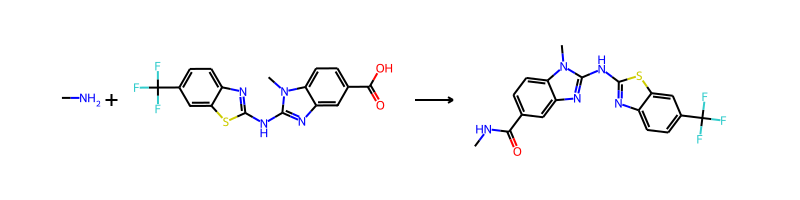

In [27]:
print(rxn_smiles)
visualize_rxn(rxn_smiles)

([C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3])>>(O-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3]).([C:4]-[NH2;D1;+0:5])


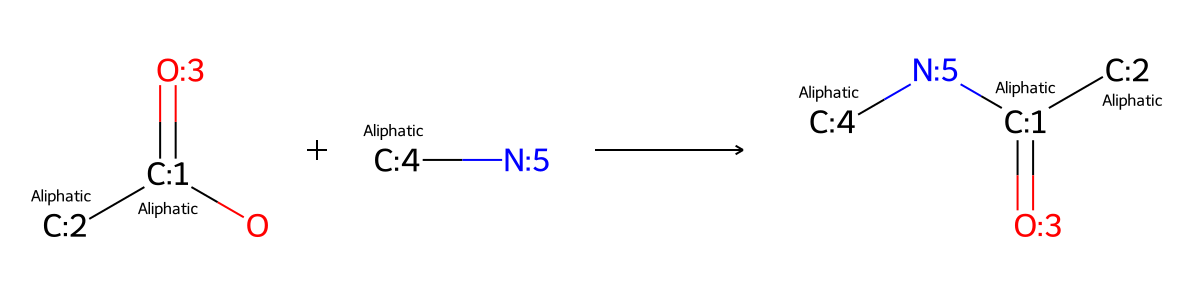

In [28]:
tpl_smiles = gallery_set[gallery_set["class"]==230].iloc[1]["retro_template"]
rxn_smiles = gallery_set[gallery_set["class"]==230].iloc[1]["reactants>reagents>production"]
print(tpl_smiles)
visualize_tpl_with_c_type(tpl_smiles)

O[C:9]([CH:8]1[CH2:7][CH2:6][N:5]([c:4]2[n:3][n:2]([CH3:1])[c:26](=[O:27])[cH:25][cH:24]2)[CH2:23][CH2:22]1)=[O:10].[NH2:11][CH2:12][CH2:13][NH:14][C:15](=[O:16])[O:17][C:18]([CH3:19])([CH3:20])[CH3:21]>>[CH3:1][n:2]1[n:3][c:4]([N:5]2[CH2:6][CH2:7][CH:8]([C:9](=[O:10])[NH:11][CH2:12][CH2:13][NH:14][C:15](=[O:16])[O:17][C:18]([CH3:19])([CH3:20])[CH3:21])[CH2:22][CH2:23]2)[cH:24][cH:25][c:26]1=[O:27]


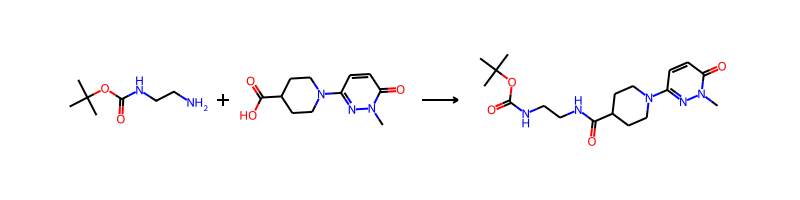

In [29]:
print(rxn_smiles)
visualize_rxn(rxn_smiles)

([C:4]-[N;H0;D3;+0:5](-[C:6])-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3])>>(O-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3]).([C:4]-[NH;D2;+0:5]-[C:6])


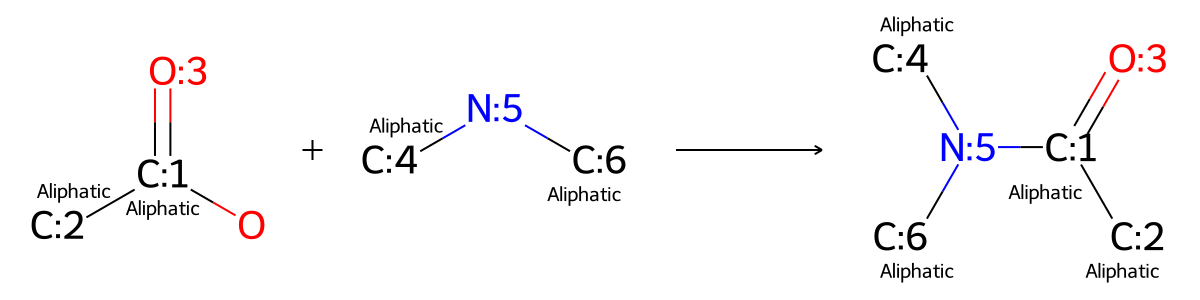

In [30]:
tpl_smiles = gallery_set[gallery_set["class"]==146].iloc[0]["retro_template"]
rxn_smiles = gallery_set[gallery_set["class"]==146].iloc[0]["reactants>reagents>production"]
print(tpl_smiles)
visualize_tpl_with_c_type(tpl_smiles)

O[C:5]([CH2:4][NH:3][C:2](=[O:1])[c:15]1[cH:16][c:17]([N+:18](=[O:19])[O-:20])[c:21]([S:22][c:23]2[c:24]([Cl:25])[cH:26][n:27][cH:28][c:29]2[Cl:30])[s:31]1)=[O:6].[NH:7]1[CH2:8][CH2:9][CH:10]([CH2:11][OH:12])[CH2:13][CH2:14]1>>[O:1]=[C:2]([NH:3][CH2:4][C:5](=[O:6])[N:7]1[CH2:8][CH2:9][CH:10]([CH2:11][OH:12])[CH2:13][CH2:14]1)[c:15]1[cH:16][c:17]([N+:18](=[O:19])[O-:20])[c:21]([S:22][c:23]2[c:24]([Cl:25])[cH:26][n:27][cH:28][c:29]2[Cl:30])[s:31]1


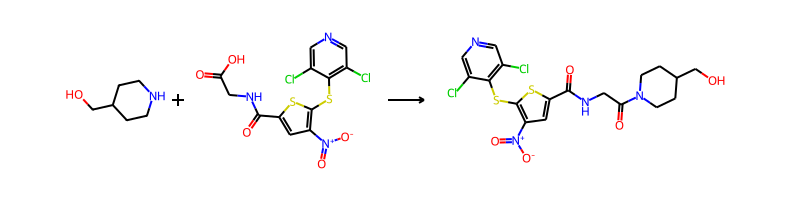

In [31]:
print(rxn_smiles)
visualize_rxn(rxn_smiles)